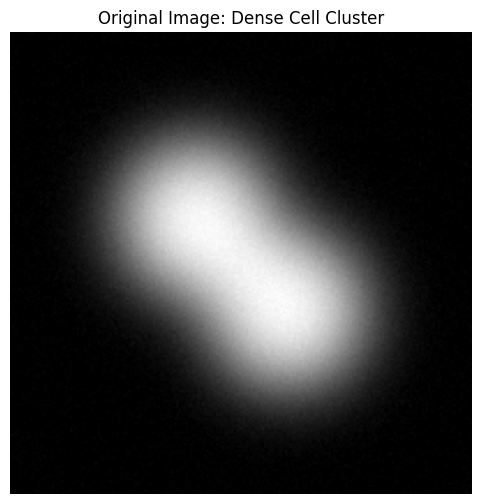

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, distance_transform_edt
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from ipywidgets import interact, FloatSlider

# --- 1. Generate a simulated "dense cell cluster" image ---

def make_multi_cell_image(img_size=200):
    """Generates a simulated image with a dense cluster of cells."""
    image = np.zeros((img_size, img_size))
    y, x = np.indices(image.shape)

    # Define cell centers and radii for a dense, overlapping cluster
    cell_specs = [
        # (center_x, center_y, radius)
        (80, 80, 33),   # Top-left of center
        (120, 120, 33), # Bottom-right of center
    ]

    for cx, cy, r in cell_specs:
        mask = (x - cx)**2 + (y - cy)**2 < r**2
        image[mask] = 1.0

    # Use a large blur to merge them into one complex blob
    image_blurry = gaussian_filter(image, sigma=15) # Increased blur

    # Add a small amount of noise
    noise = np.random.normal(loc=0.0, scale=0.01, size=image.shape)
    image_final = np.clip(image_blurry + noise, 0, 1)

    return image_final

# Create and store our global image
global_image = make_multi_cell_image()

# Plot the image to see what we're working with
plt.figure(figsize=(6, 6))
plt.imshow(global_image, cmap='gray')
plt.title("Original Image: Dense Cell Cluster")
plt.axis('off')
plt.show()

Watershed analysis complete.
Final cell count: 2


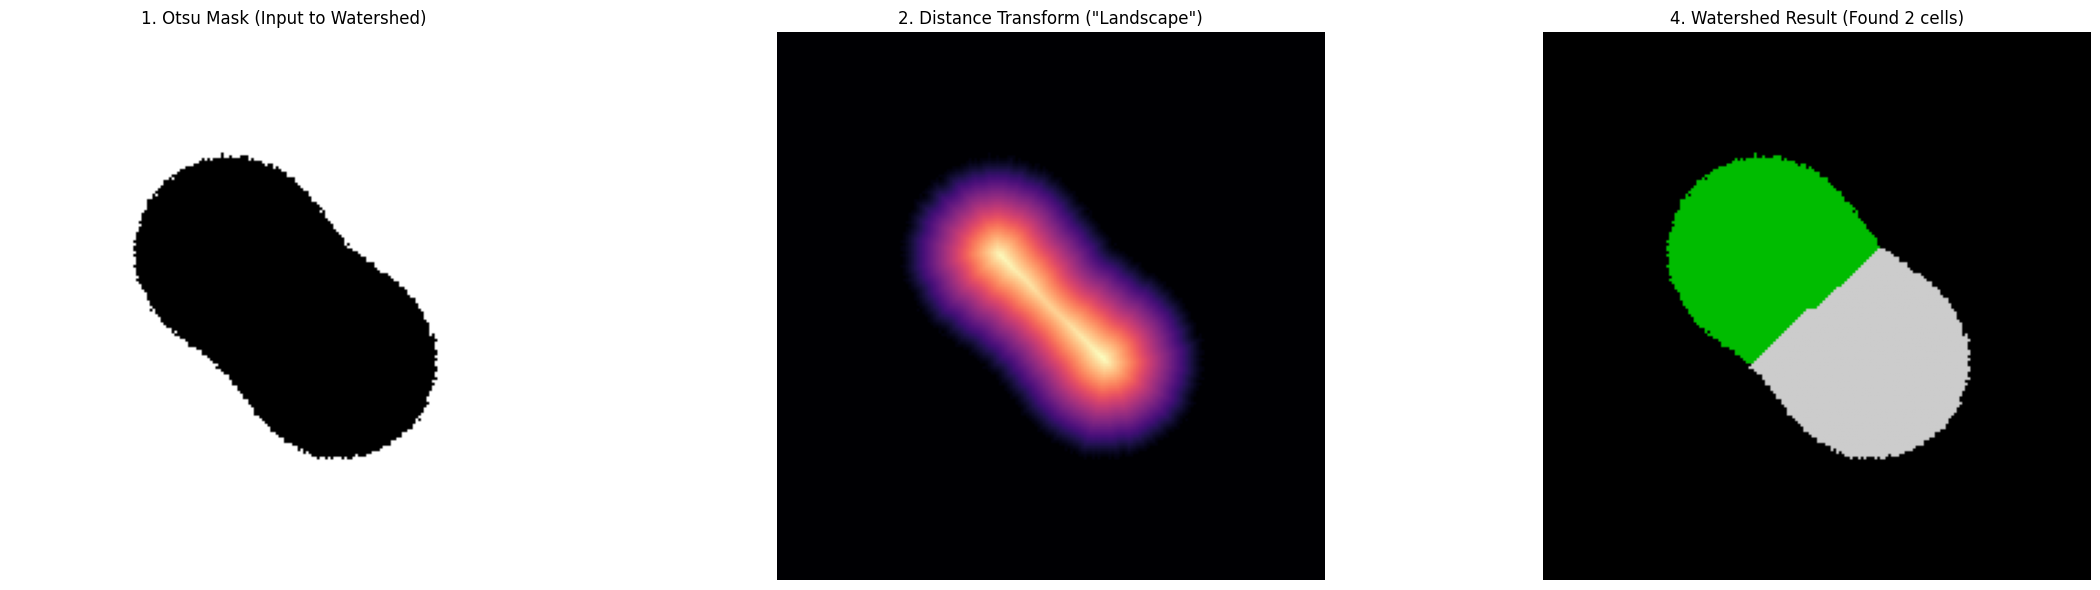

In [2]:
# Calculate Otsu's automatic threshold
otsu_thresh = threshold_otsu(global_image)

# Apply the threshold
otsu_mask = global_image > otsu_thresh

# Count the objects
labeled_otsu, num_objects_otsu = label(otsu_mask, connectivity=1, return_num=True)


# We will use the Otsu mask from the previous step as our starting point
binary_mask_for_watershed = otsu_mask

# --- The Watershed Workflow ---

# 1. Calculate the Distance Transform
distance = distance_transform_edt(binary_mask_for_watershed)

# 2. Find the "seeds" (the "peaks" of the landscape)
# 'min_distance' ensures the peaks are separated (a key parameter!)
# We might need to adjust min_distance for this denser cluster
seed_coords = peak_local_max(distance, min_distance=15, labels=binary_mask_for_watershed)
seeds_mask = np.zeros(distance.shape, dtype=bool)
seeds_mask[tuple(seed_coords.T)] = True
seeds_labeled = label(seeds_mask)

# 3. Run the Watershed "flooding" algorithm
watershed_labels = watershed(-distance, seeds_labeled, mask=binary_mask_for_watershed)

# 4. Count the final objects
final_cell_count = seeds_labeled.max()
print(f"Watershed analysis complete.")
print(f"Final cell count: {final_cell_count}")

# --- Plot all the steps ---
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

axs[0].imshow(binary_mask_for_watershed, cmap='gray_r')
axs[0].set_title('1. Otsu Mask (Input to Watershed)')
axs[0].axis('off')

axs[1].imshow(distance, cmap='magma')
axs[1].set_title('2. Distance Transform ("Landscape")')
axs[1].axis('off')

axs[2].imshow(watershed_labels, cmap='nipy_spectral')
axs[2].set_title(f'4. Watershed Result (Found {final_cell_count} cells)')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Real examples

## Without watershed

Loading image from: https://docs.opencv.org/4.x/water_coins.jpg
Success! Image loaded, shape: (312, 252, 3)
Thresholding analysis complete.
Final cell count (without watershed): 1


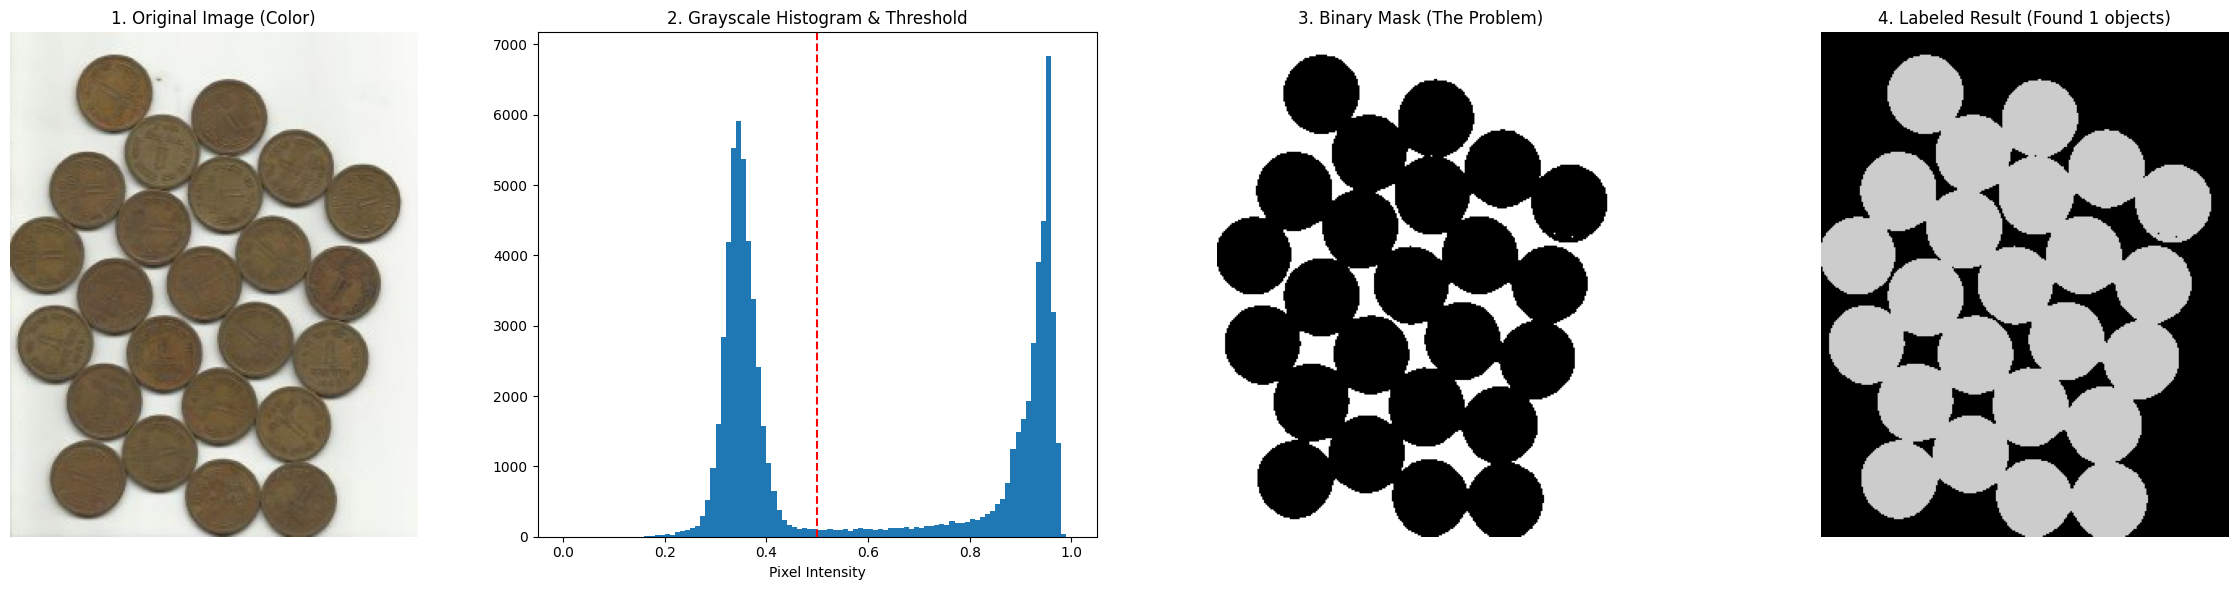

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# from scipy.ndimage import distance_transform_edt # <-- Removed watershed step
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label
# from skimage.feature import peak_local_max # <-- Removed watershed step
# from skimage.segmentation import watershed # <-- Removed watershed step

# --- 1. Define the URL ---
url = "https://docs.opencv.org/4.x/water_coins.jpg"

# --- 2. Load the image directly from the URL ---
print(f"Loading image from: {url}")
try:
    image_from_url = io.imread(url)
    print(f"Success! Image loaded, shape: {image_from_url.shape}")
except Exception as e:
    print(f"Error loading image: {e}")

# Keep the original color image for plotting
coins_color = image_from_url

# --- 3. Convert the image to grayscale for processing ---
coins_gray = rgb2gray(coins_color)

# --- 4. Run Manual Threshold on the GRAYSCALE image ---
tresh = 0.5
binary_mask_for_watershed = coins_gray < tresh

# --- The "Without Watershed" Workflow ---

# 1. Label the binary mask directly
# This is the result of segmentation without watershed
labeled_mask, final_cell_count = label(binary_mask_for_watershed, connectivity=1, return_num=True)

print(f"Thresholding analysis complete.")
print(f"Final cell count (without watershed): {final_cell_count}")

# --- Plot all the steps ---
# Changed from 6 plots to 4
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Plot 1: Show the *original color* image
axs[0].imshow(coins_color)
axs[0].set_title('1. Original Image (Color)')
axs[0].axis('off')

# Plot 2: Show the histogram and threshold
axs[1].hist(coins_gray.ravel(), bins=100, range=(0, 1))
axs[1].axvline(tresh, color='r', linestyle='--')
axs[1].set_title('2. Grayscale Histogram & Threshold')
axs[1].set_xlabel('Pixel Intensity')

# Plot 3: Show the binary mask from the grayscale image
axs[2].imshow(binary_mask_for_watershed, cmap='gray_r')
axs[2].set_title('3. Binary Mask (The Problem)')
axs[2].axis('off')

# Plot 4: Show the final 2D labeled image
axs[3].imshow(labeled_mask, cmap='nipy_spectral')
axs[3].set_title(f'4. Labeled Result (Found {final_cell_count} objects)')
axs[3].axis('off')

plt.tight_layout()
plt.show()

Watershed analysis complete.
Final cell count: 24


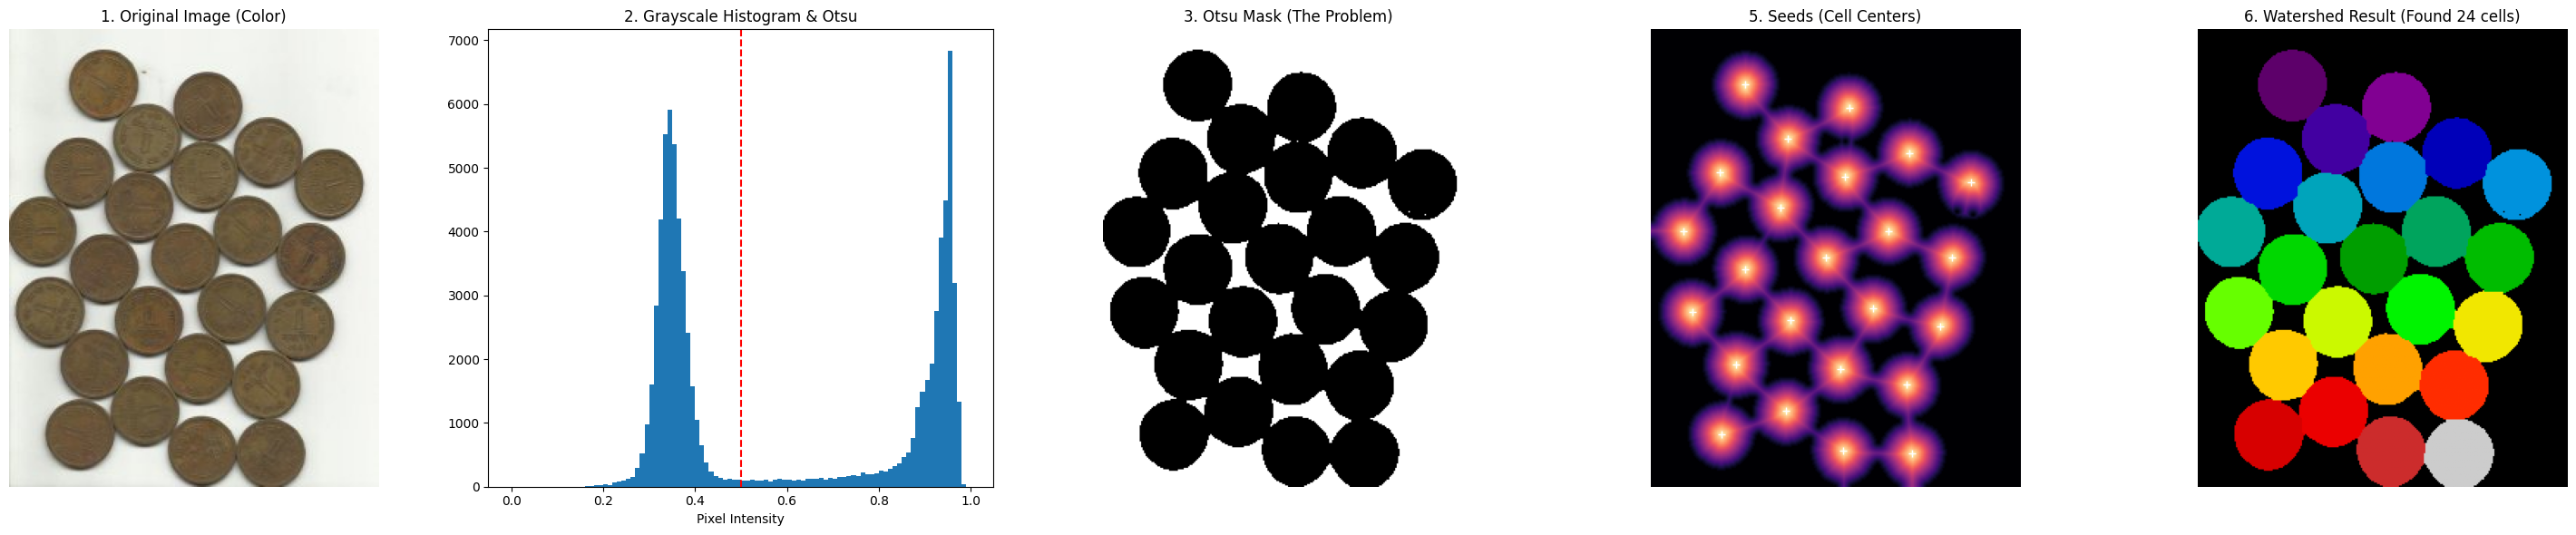

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# --- 4. Run Otsu on the GRAYSCALE image ---
# tresh = threshold_otsu(coins_gray)
tresh = 0.5
mask = coins_gray < tresh
# We set this variable to match your code
binary_mask_for_watershed = mask

# --- The Watershed Workflow (Your Code) ---

# 1. Calculate the Distance Transform
distance = distance_transform_edt(binary_mask_for_watershed)

# 2. Find the "seeds" (the "peaks" of the landscape)
seed_coords = peak_local_max(distance, min_distance=10, labels=binary_mask_for_watershed)
seeds_mask = np.zeros(distance.shape, dtype=bool)
seeds_mask[tuple(seed_coords.T)] = True
seeds_labeled = label(seeds_mask)

# 3. Run the Watershed "flooding" algorithm
watershed_labels = watershed(-distance, seeds_labeled, mask=binary_mask_for_watershed)

# 4. Count the final objects
final_cell_count = seeds_labeled.max()
print(f"Watershed analysis complete.")
print(f"Final cell count: {final_cell_count}")

# --- Plot all the steps ---
fig, axs = plt.subplots(1, 5, figsize=(30, 6))

# Plot 1: Show the *original color* image
axs[0].imshow(coins_color)
axs[0].set_title('1. Original Image (Color)')
axs[0].axis('off')

# --- NEW PLOT ---
# Plot 2: Show the histogram and Otsu threshold
axs[1].hist(coins_gray.ravel(), bins=100, range=(0, 1))
axs[1].axvline(tresh, color='r', linestyle='--')
axs[1].set_title('2. Grayscale Histogram & Otsu')
axs[1].set_xlabel('Pixel Intensity')
# --- END NEW PLOT ---

# Plot 3: Show the binary mask from the grayscale image
axs[2].imshow(binary_mask_for_watershed, cmap='gray_r')
axs[2].set_title('3. Otsu Mask (The Problem)')
axs[2].axis('off')

# Plot 5: Show the seeds on the 2D distance transform
axs[3].imshow(distance, cmap='magma')
axs[3].plot(seed_coords[:, 1], seed_coords[:, 0], 'w+') # White crosses
axs[3].set_title('5. Seeds (Cell Centers)')
axs[3].axis('off')

# Plot 6: Show the final 2D labeled image
axs[4].imshow(watershed_labels, cmap='nipy_spectral')

axs[4].set_title(f'6. Watershed Result (Found {final_cell_count} cells)')
axs[4].axis('off')

plt.tight_layout()
plt.show()

# Complex image

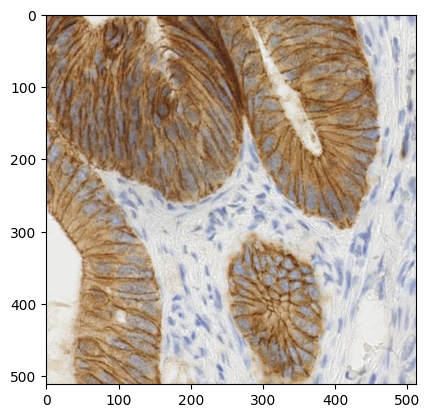

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.data import immunohistochemistry
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# --- 1. Load and convert the image ---
image_ihc = immunohistochemistry()
plt.imshow(image_ihc)
plt.show()

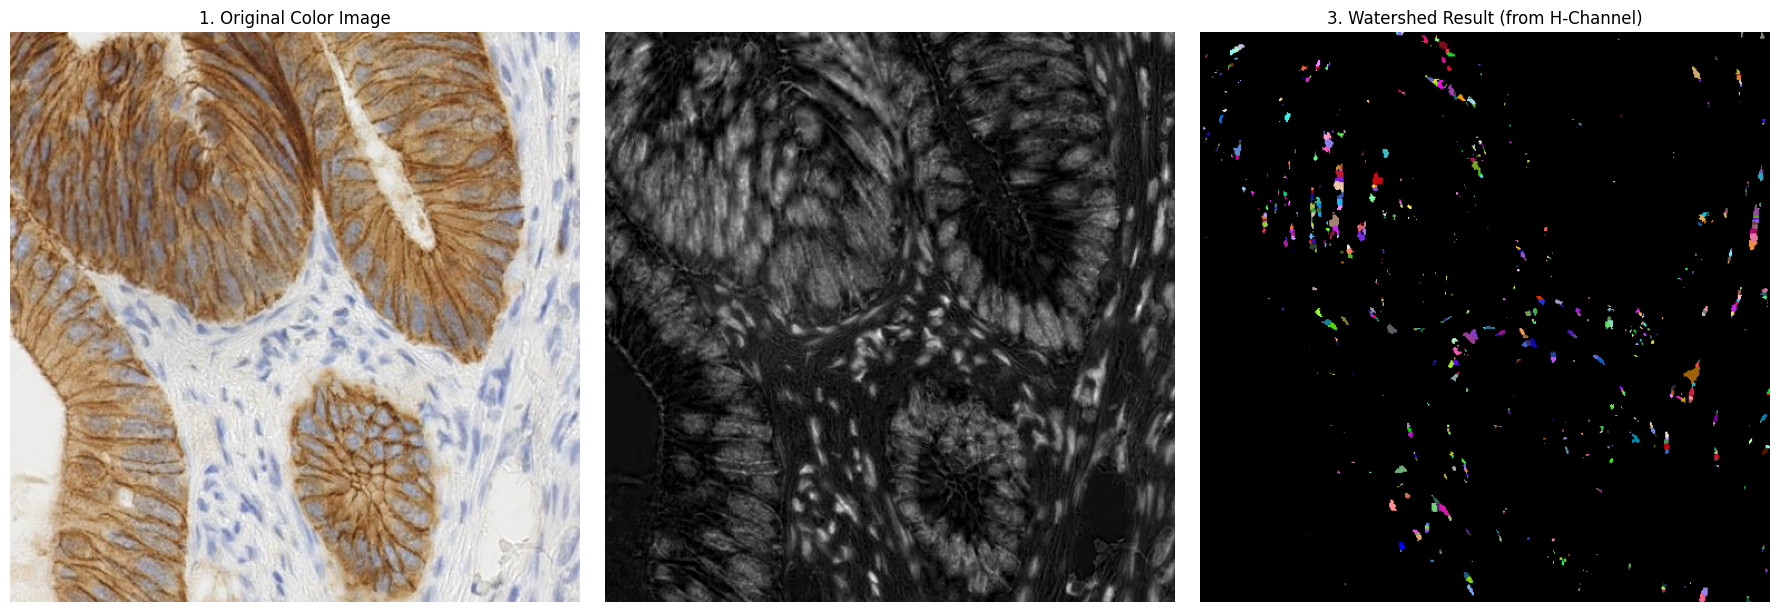

Total 'objects' found: 756
Result: Still an over-segmented, 'shattered' mask.
Even with a specific channel, simple thresholding is too noisy for watershed.


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.data import immunohistochemistry
from skimage.measure import label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from matplotlib.colors import ListedColormap

# --- New imports for IHC deconvolution ---
from skimage.color import rgb2hed
from skimage.exposure import rescale_intensity

# --- 1. Load the Image and Deconvolve ---
image_ihc = immunohistochemistry()

# Perform Color Deconvolution
ihc_hed = rgb2hed(image_ihc)

# --- Change: Select the Hematoxylin (H) channel ---
# This channel contains the nuclei (blue stain)
# We rescale it to 0-1 for processing
image_h_channel = rescale_intensity(ihc_hed[:, :, 0], out_range=(0.0, 1.0))

# --- 2. Create a binary mask ---
# The H-channel is already "inverted" (nuclei are dark, 0.0)
# We want the nuclei, which have HIGH values in this channel
# So we can threshold it directly (no need to invert)
threshold = 0.5 # Using a fixed threshold

binary_mask = image_h_channel > threshold

# --- 3. Run the Watershed workflow ---
distance = distance_transform_edt(binary_mask)

# Using a low min_distance will find many "seeds" and show over-segmentation
seed_coords = peak_local_max(distance, min_distance=2, labels=binary_mask)
seeds_mask = np.zeros(distance.shape, dtype=bool)
seeds_mask[tuple(seed_coords.T)] = True
seeds_labeled = label(seeds_mask)

watershed_labels = watershed(-distance, seeds_labeled, mask=binary_mask)

# --- 4. Generate Random Colormap ---
num_objects = seeds_labeled.max()
colors = [[0, 0, 0]]
for _ in range(num_objects):
    colors.append(np.random.rand(3))
random_cmap = ListedColormap(colors)

# --- 5. Plot the Failure ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(image_ihc)
axs[0].set_title("1. Original Color Image")
axs[0].axis('off')


axs[1].imshow(image_h_channel, cmap='gray')
axs[1].axis('off')


axs[2].imshow(watershed_labels, cmap=random_cmap)
axs[2].set_title("3. Watershed Result (from H-Channel)")
axs[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Total 'objects' found: {num_objects}")
print("Result: Still an over-segmented, 'shattered' mask.")
print("Even with a specific channel, simple thresholding is too noisy for watershed.")

# Other Methods

Image loaded successfully. Using H-channel for all segmentation...
Running K-Means...
K-Means complete.
Running Mean-Shift...
Estimating bandwidth...
Estimated bandwidth: 0.02888640183486241
Mean-Shift found 5 clusters.
Mean-Shift complete.
Running Canny Edge Detection...
Canny Edge Detection complete.
Displaying results...


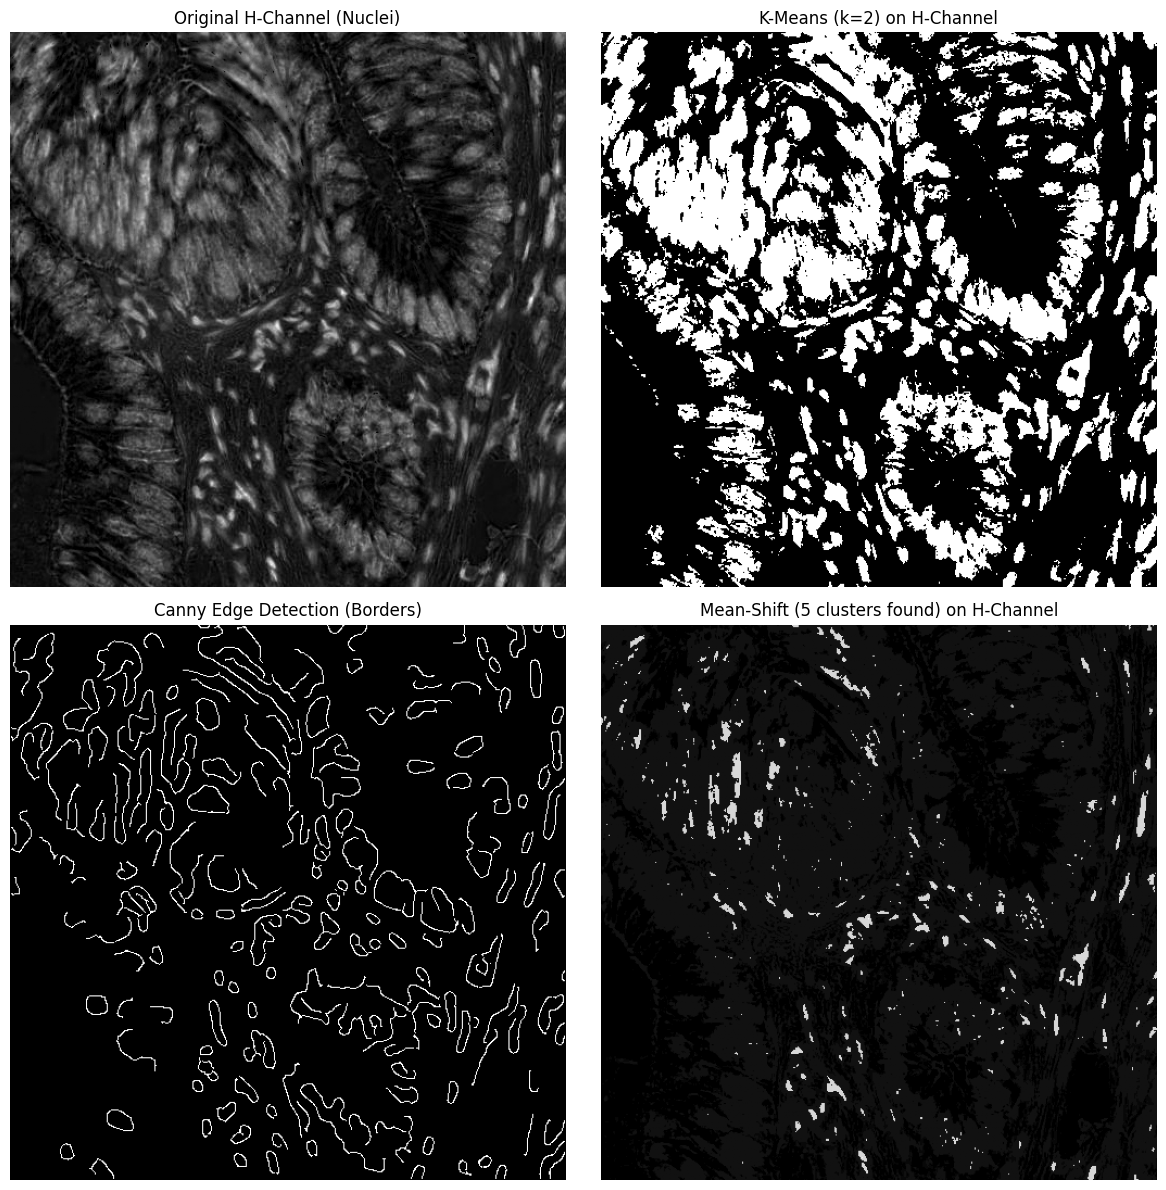

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from skimage.filters import gaussian
from skimage.color import rgb2gray

# Import the new libraries
from skimage.color import rgb2hed
from skimage.exposure import rescale_intensity
from skimage.data import immunohistochemistry
from skimage.feature import canny  # --- Import Canny Edge Detection ---

# --- 1-3. Load and Deconvolve Image (Same as before) ---
image_ihc = immunohistochemistry()
ihc_hed = rgb2hed(image_ihc)
h_channel = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1))

# --- 4. PREPARE IMAGES (Same as before) ---
pixels = h_channel.reshape((-1, 1))
img_gray = h_channel
print("Image loaded successfully. Using H-channel for all segmentation...")

# --- 5. K-MEANS CLUSTERING (Same as before) ---
print("Running K-Means...")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(pixels)
centers_kmeans = kmeans.cluster_centers_.astype(float)
labels_kmeans = kmeans.labels_
segmented_img_kmeans = centers_kmeans[labels_kmeans].reshape(h_channel.shape)
print("K-Means complete.")

# --- 6. MEAN-SHIFT CLUSTERING (Same as before) ---
print("Running Mean-Shift...")
print("Estimating bandwidth...")
pixels_sample = np.random.permutation(pixels)[::100][:3000]
bw = estimate_bandwidth(pixels_sample, quantile=0.1)
print(f"Estimated bandwidth: {bw}")
if bw == 0:
    bw = 0.01
mean_shift = MeanShift(bandwidth=bw, bin_seeding=True)
mean_shift.fit(pixels)
centers_ms = mean_shift.cluster_centers_.astype(float)
labels_ms = mean_shift.labels_
num_clusters_ms = len(np.unique(labels_ms))
print(f"Mean-Shift found {num_clusters_ms} clusters.")
segmented_img_ms = centers_ms[labels_ms].reshape(h_channel.shape)
print("Mean-Shift complete.")

# --- 7. ALGORITHM 3: CANNY EDGE DETECTION (NEW) ---
print("Running Canny Edge Detection...")

# The algorithm works best on a slightly blurred image
# to reduce noise. We'll use the blurred H-channel.
img_blur = gaussian(img_gray, 3)

# Run the Canny algorithm
# sigma=1 is a good starting point for the blur
# It will automatically find the low and high thresholds
edges = canny(img_blur, sigma=1)

print("Canny Edge Detection complete.")

# --- 8. PLOT ALL RESULTS (Updated) ---
print("Displaying results...")
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
ax = axes.ravel()

ax[0].imshow(h_channel, cmap='gray')
ax[0].set_title("Original H-Channel (Nuclei)")
ax[0].axis('off')

ax[1].imshow(segmented_img_kmeans, cmap='gray')
ax[1].set_title(f"K-Means (k={kmeans.n_clusters}) on H-Channel")
ax[1].axis('off')

# --- Updated Plot ---
# Plot 3: Canny Edge Detection
ax[2].imshow(edges, cmap='gray') # 'cmap=gray' shows the boolean as B&W
ax[2].set_title("Canny Edge Detection (Borders)")
ax[2].axis('off')

ax[3].imshow(segmented_img_ms, cmap='gray')
ax[3].set_title(f"Mean-Shift ({num_clusters_ms} clusters found) on H-Channel")
ax[3].axis('off')

plt.tight_layout()
plt.show()